# Tier 1: CNN + BiLSTM Training

This notebook implements training for the **Tier 1** architecture:
- Multi-scale 1D CNN for local feature extraction
- Stacked BiLSTM for sequential modeling
- Dual output heads for Q8 and Q3 prediction

## Expected Performance
- Q3 Accuracy: ~82-85%
- Q8 Accuracy: ~70-74%

## 1. Setup & Configuration

In [1]:
import sys
sys.path.insert(0, '../..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import random
import os

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Import our modules
from src.config import Tier1Config, LEAKAGE_TRAIN_IDS
from src.data import ProteinDataset, create_dataloaders, collate_fn
from src.models.tier1_cnn_bilstm import CNNBiLSTM
from src.losses import get_multitask_loss
from src.augmentation import SequenceAugmenter, describe_augmentation_levels
from src.metrics import evaluate_model, plot_confusion_matrix, EvaluationReport
from src.training import Trainer, create_optimizer, create_scheduler, plot_training_history

## 2. Configuration

In [3]:
# Experiment configuration
config = Tier1Config(
    # Data
    max_seq_length=512,
    batch_size=32,
    
    # Model
    input_dim=40,  # 20 (one-hot) + 20 (BLOSUM62)
    use_blosum=True,
    cnn_filters=64,
    cnn_kernels=[3, 5, 7],
    lstm_hidden=256,
    lstm_layers=2,
    lstm_dropout=0.1,
    fc_hidden=256,
    fc_dropout=0.1,
    
    # Training
    learning_rate=1e-4,
    weight_decay=0.01,
    max_epochs=50,
    patience=10,
    gradient_clip=1.0,
    
    # Loss
    focal_gamma=2.0,
    q8_loss_weight=1.0,
    q3_loss_weight=0.5,
    
    # Augmentation
    augmentation_level=1,  # Light masking
    
    # Checkpointing
    checkpoint_dir='../../checkpoints/tier1_cnn_bilstm',
)

print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Batch size: {config.batch_size}")
print(f"  Max sequence length: {config.max_seq_length}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Augmentation level: {config.augmentation_level}")

Configuration:
  Model: tier1_cnn_bilstm
  Batch size: 32
  Max sequence length: 512
  Learning rate: 0.0001
  Augmentation level: 1


## 3. Data Loading

In [4]:
# Preview augmentation levels
describe_augmentation_levels()

AUGMENTATION LEVELS

Level 1: No augmentation (baseline)
  - Mask prob: 0.0
  - Substitute prob: 0.0
  - Crop prob: 0.0
  - Noise std: 0.0
  - Reverse prob: 0.0

Level 2: Light masking (5%)
  - Mask prob: 0.05
  - Substitute prob: 0.0
  - Crop prob: 0.0
  - Noise std: 0.0
  - Reverse prob: 0.0

Level 3: Moderate: masking (10%) + substitution (3%) + noise
  - Mask prob: 0.1
  - Substitute prob: 0.03
  - Crop prob: 0.0
  - Noise std: 0.01
  - Reverse prob: 0.0

Level 4: Aggressive: masking (15%) + substitution (5%) + cropping (20%)
  - Mask prob: 0.15
  - Substitute prob: 0.05
  - Crop prob: 0.2
  - Noise std: 0.02
  - Reverse prob: 0.0

Level 5: Experimental: heavy masking (20%) + all augmentations + reversal (10%)
  - Mask prob: 0.2
  - Substitute prob: 0.08
  - Crop prob: 0.3
  - Noise std: 0.03
  - Reverse prob: 0.1


In [5]:
# Create augmenter
augmenter = SequenceAugmenter(level=config.augmentation_level, seed=SEED)
print(f"\nUsing augmentation: {augmenter}")


Using augmentation: SequenceAugmenter(level=1, config=AugmentationConfig(mask_prob=0.0, substitute_prob=0.0, noise_std=0.0, crop_prob=0.0, min_crop_ratio=0.8, reverse_prob=0.0))


In [6]:
# Create data loaders
train_loader, val_loader = create_dataloaders(
    train_csv='../../data/train.csv',
    val_split=0.1,
    batch_size=config.batch_size,
    max_length=config.max_seq_length,
    use_blosum=config.use_blosum,
    use_positional=False,
    augmentation=augmenter,
    num_workers=4,
    seed=SEED,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 205
Val batches: 23


In [7]:
# Inspect a batch
sample_batch = next(iter(train_loader))
print(f"\nBatch contents:")
print(f"  Features shape: {sample_batch['features'].shape}")
print(f"  SST8 shape: {sample_batch['sst8'].shape}")
print(f"  SST3 shape: {sample_batch['sst3'].shape}")
print(f"  Lengths: {sample_batch['lengths'][:5]}")


Batch contents:
  Features shape: torch.Size([32, 512, 40])
  SST8 shape: torch.Size([32, 512])
  SST3 shape: torch.Size([32, 512])
  Lengths: tensor([512, 512, 512, 497, 393])


## 4. Model Initialization

In [8]:
# Create model
model = CNNBiLSTM(
    input_dim=config.input_dim,
    cnn_filters=config.cnn_filters,
    cnn_kernels=config.cnn_kernels,
    lstm_hidden=config.lstm_hidden,
    lstm_layers=config.lstm_layers,
    lstm_dropout=config.lstm_dropout,
    fc_hidden=config.fc_hidden,
    fc_dropout=config.fc_dropout,
)

print(model)
print(f"\nTotal parameters: {model.count_parameters():,}")

CNNBiLSTM(
  CNN: 192 channels
  BiLSTM: 512 hidden
  Parameters: 2,803,019
)

Total parameters: 2,803,019


In [9]:
# Test forward pass
model = model.to(DEVICE)
test_input = sample_batch['features'].to(DEVICE)
q8_out, q3_out = model(test_input)
print(f"Q8 output shape: {q8_out.shape}")
print(f"Q3 output shape: {q3_out.shape}")

Q8 output shape: torch.Size([32, 512, 8])
Q3 output shape: torch.Size([32, 512, 3])


## 5. Loss Function Setup

In [10]:
# Create multi-task loss with focal loss and class weights
loss_fn = get_multitask_loss(
    loss_type='focal',
    q8_weight=config.q8_loss_weight,
    q3_weight=config.q3_loss_weight,
    dynamic_weights=False,
    gamma=config.focal_gamma,
)

print(f"Loss function: {loss_fn}")

Loss function: MultiTaskLoss(
  (q8_loss_fn): FocalLoss()
  (q3_loss_fn): FocalLoss()
)


## 6. Training

In [11]:
# Create optimizer and scheduler
optimizer = create_optimizer(
    model,
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    optimizer_type='adamw',
)

scheduler = create_scheduler(
    optimizer,
    scheduler_type='cosine',
    num_epochs=config.max_epochs,
)

In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    checkpoint_dir=config.checkpoint_dir,
    gradient_clip=config.gradient_clip,
    log_every=100,
    use_amp=torch.cuda.is_available(),  # Use FP16 on GPU
    use_tracking=True,
    experiment_name='tier1_cnn_bilstm',
    hub_model_id='thethinkmachine/ProteinSST-CNNBiLSTM',
    training_config=config,
)

In [13]:
# Train!
history = trainer.train(
    num_epochs=config.max_epochs,
    patience=config.patience,
    save_every=5,
)

Starting training for 50 epochs...
Device: cuda
Model parameters: 2,803,019


Epoch 1: 100%|██████████| 205/205 [00:09<00:00, 21.44it/s, loss=1.04, q8_loss=0.904, q3_loss=0.281] 


Epoch 1/50 (10.2s) | Train Loss: 1.0359 | Val Loss: 0.9031 | Q8 Acc: 0.4393 | Q3 Acc: 0.6537 | Q8 F1: 0.2807 | Q3 F1: 0.6457 | H-F1: 0.3913 | LR: 0.000099 *


Epoch 2: 100%|██████████| 205/205 [00:08<00:00, 22.93it/s, loss=1.06, q8_loss=0.929, q3_loss=0.255] 


Epoch 2/50 (9.6s) | Train Loss: 0.9281 | Val Loss: 0.8652 | Q8 Acc: 0.4469 | Q3 Acc: 0.6698 | Q8 F1: 0.2923 | Q3 F1: 0.6637 | H-F1: 0.4058 | LR: 0.000096 *


Epoch 3: 100%|██████████| 205/205 [00:09<00:00, 22.53it/s, loss=1.07, q8_loss=0.93, q3_loss=0.277]  


Epoch 3/50 (9.8s) | Train Loss: 0.9011 | Val Loss: 0.8448 | Q8 Acc: 0.4556 | Q3 Acc: 0.6684 | Q8 F1: 0.2983 | Q3 F1: 0.6654 | H-F1: 0.4119 | LR: 0.000092 *


Epoch 4: 100%|██████████| 205/205 [00:09<00:00, 22.22it/s, loss=0.822, q8_loss=0.708, q3_loss=0.228]


Epoch 4/50 (9.9s) | Train Loss: 0.8829 | Val Loss: 0.8348 | Q8 Acc: 0.4813 | Q3 Acc: 0.6661 | Q8 F1: 0.3037 | Q3 F1: 0.6632 | H-F1: 0.4166 | LR: 0.000086 *


Epoch 5: 100%|██████████| 205/205 [00:09<00:00, 22.62it/s, loss=0.882, q8_loss=0.759, q3_loss=0.246]


Epoch 5/50 (9.8s) | Train Loss: 0.8715 | Val Loss: 0.8281 | Q8 Acc: 0.4552 | Q3 Acc: 0.6786 | Q8 F1: 0.3019 | Q3 F1: 0.6754 | H-F1: 0.4173 | LR: 0.000078 *


Epoch 6: 100%|██████████| 205/205 [00:09<00:00, 22.50it/s, loss=0.833, q8_loss=0.721, q3_loss=0.225]


Epoch 6/50 (9.8s) | Train Loss: 0.8608 | Val Loss: 0.8339 | Q8 Acc: 0.4568 | Q3 Acc: 0.6903 | Q8 F1: 0.3070 | Q3 F1: 0.6816 | H-F1: 0.4233 | LR: 0.000069 *


Epoch 7: 100%|██████████| 205/205 [00:09<00:00, 22.50it/s, loss=0.944, q8_loss=0.821, q3_loss=0.246]


Epoch 7/50 (9.8s) | Train Loss: 0.8514 | Val Loss: 0.8150 | Q8 Acc: 0.4874 | Q3 Acc: 0.6802 | Q8 F1: 0.3130 | Q3 F1: 0.6763 | H-F1: 0.4280 | LR: 0.000060 *


Epoch 8: 100%|██████████| 205/205 [00:09<00:00, 22.55it/s, loss=0.825, q8_loss=0.717, q3_loss=0.215]


Epoch 8/50 (9.6s) | Train Loss: 0.8453 | Val Loss: 0.8251 | Q8 Acc: 0.4645 | Q3 Acc: 0.6864 | Q8 F1: 0.3086 | Q3 F1: 0.6789 | H-F1: 0.4244 | LR: 0.000051


Epoch 9: 100%|██████████| 205/205 [00:08<00:00, 22.96it/s, loss=0.775, q8_loss=0.663, q3_loss=0.223]


Epoch 9/50 (9.6s) | Train Loss: 0.8385 | Val Loss: 0.8059 | Q8 Acc: 0.4902 | Q3 Acc: 0.6891 | Q8 F1: 0.3180 | Q3 F1: 0.6852 | H-F1: 0.4344 | LR: 0.000041 *


Epoch 10: 100%|██████████| 205/205 [00:09<00:00, 22.76it/s, loss=0.826, q8_loss=0.715, q3_loss=0.222]


Epoch 10/50 (9.5s) | Train Loss: 0.8320 | Val Loss: 0.8086 | Q8 Acc: 0.4871 | Q3 Acc: 0.6885 | Q8 F1: 0.3175 | Q3 F1: 0.6831 | H-F1: 0.4335 | LR: 0.000032


Epoch 11: 100%|██████████| 205/205 [00:09<00:00, 22.77it/s, loss=0.74, q8_loss=0.643, q3_loss=0.192] 


Epoch 11/50 (9.7s) | Train Loss: 0.8284 | Val Loss: 0.8078 | Q8 Acc: 0.4962 | Q3 Acc: 0.6943 | Q8 F1: 0.3250 | Q3 F1: 0.6890 | H-F1: 0.4417 | LR: 0.000023 *


Epoch 12: 100%|██████████| 205/205 [00:09<00:00, 22.72it/s, loss=0.85, q8_loss=0.726, q3_loss=0.249] 


Epoch 12/50 (9.6s) | Train Loss: 0.8228 | Val Loss: 0.8007 | Q8 Acc: 0.4775 | Q3 Acc: 0.6945 | Q8 F1: 0.3179 | Q3 F1: 0.6902 | H-F1: 0.4353 | LR: 0.000015


Epoch 13: 100%|██████████| 205/205 [00:09<00:00, 22.42it/s, loss=0.774, q8_loss=0.677, q3_loss=0.194]


Epoch 13/50 (9.7s) | Train Loss: 0.8177 | Val Loss: 0.8057 | Q8 Acc: 0.4881 | Q3 Acc: 0.6943 | Q8 F1: 0.3193 | Q3 F1: 0.6880 | H-F1: 0.4361 | LR: 0.000009


Epoch 14: 100%|██████████| 205/205 [00:08<00:00, 22.88it/s, loss=0.759, q8_loss=0.646, q3_loss=0.226]


Epoch 14/50 (9.5s) | Train Loss: 0.8161 | Val Loss: 0.8033 | Q8 Acc: 0.4923 | Q3 Acc: 0.6937 | Q8 F1: 0.3211 | Q3 F1: 0.6881 | H-F1: 0.4378 | LR: 0.000005


Epoch 15: 100%|██████████| 205/205 [00:09<00:00, 22.47it/s, loss=0.7, q8_loss=0.596, q3_loss=0.209]  


Epoch 15/50 (9.7s) | Train Loss: 0.8143 | Val Loss: 0.7985 | Q8 Acc: 0.4857 | Q3 Acc: 0.6940 | Q8 F1: 0.3198 | Q3 F1: 0.6899 | H-F1: 0.4371 | LR: 0.000002


Epoch 16: 100%|██████████| 205/205 [00:09<00:00, 22.76it/s, loss=0.769, q8_loss=0.67, q3_loss=0.197] 


Epoch 16/50 (9.6s) | Train Loss: 0.8127 | Val Loss: 0.7977 | Q8 Acc: 0.4896 | Q3 Acc: 0.6930 | Q8 F1: 0.3216 | Q3 F1: 0.6893 | H-F1: 0.4386 | LR: 0.000100


Epoch 17: 100%|██████████| 205/205 [00:08<00:00, 22.85it/s, loss=0.881, q8_loss=0.768, q3_loss=0.226]


Epoch 17/50 (9.5s) | Train Loss: 0.8280 | Val Loss: 0.8031 | Q8 Acc: 0.4781 | Q3 Acc: 0.6984 | Q8 F1: 0.3183 | Q3 F1: 0.6925 | H-F1: 0.4362 | LR: 0.000100


Epoch 18: 100%|██████████| 205/205 [00:08<00:00, 23.05it/s, loss=0.839, q8_loss=0.693, q3_loss=0.292]


Epoch 18/50 (9.4s) | Train Loss: 0.8209 | Val Loss: 0.7991 | Q8 Acc: 0.4919 | Q3 Acc: 0.6934 | Q8 F1: 0.3189 | Q3 F1: 0.6895 | H-F1: 0.4361 | LR: 0.000099


Epoch 19: 100%|██████████| 205/205 [00:09<00:00, 22.44it/s, loss=0.81, q8_loss=0.707, q3_loss=0.205] 


Epoch 19/50 (9.8s) | Train Loss: 0.8133 | Val Loss: 0.7980 | Q8 Acc: 0.4843 | Q3 Acc: 0.7009 | Q8 F1: 0.3269 | Q3 F1: 0.6960 | H-F1: 0.4448 | LR: 0.000098 *


Epoch 20: 100%|██████████| 205/205 [00:09<00:00, 22.46it/s, loss=0.847, q8_loss=0.738, q3_loss=0.219]


Epoch 20/50 (9.7s) | Train Loss: 0.8087 | Val Loss: 0.7954 | Q8 Acc: 0.4847 | Q3 Acc: 0.6996 | Q8 F1: 0.3263 | Q3 F1: 0.6956 | H-F1: 0.4443 | LR: 0.000096


Epoch 21: 100%|██████████| 205/205 [00:09<00:00, 22.72it/s, loss=0.959, q8_loss=0.829, q3_loss=0.26] 


Epoch 21/50 (9.6s) | Train Loss: 0.7999 | Val Loss: 0.8056 | Q8 Acc: 0.4733 | Q3 Acc: 0.6783 | Q8 F1: 0.3154 | Q3 F1: 0.6767 | H-F1: 0.4302 | LR: 0.000094


Epoch 22: 100%|██████████| 205/205 [00:09<00:00, 22.74it/s, loss=0.632, q8_loss=0.537, q3_loss=0.191]


Epoch 22/50 (9.6s) | Train Loss: 0.7963 | Val Loss: 0.7886 | Q8 Acc: 0.4947 | Q3 Acc: 0.6966 | Q8 F1: 0.3271 | Q3 F1: 0.6934 | H-F1: 0.4445 | LR: 0.000092


Epoch 23: 100%|██████████| 205/205 [00:08<00:00, 22.95it/s, loss=0.852, q8_loss=0.726, q3_loss=0.251]


Epoch 23/50 (9.5s) | Train Loss: 0.7862 | Val Loss: 0.7984 | Q8 Acc: 0.5110 | Q3 Acc: 0.6864 | Q8 F1: 0.3277 | Q3 F1: 0.6845 | H-F1: 0.4432 | LR: 0.000089


Epoch 24: 100%|██████████| 205/205 [00:09<00:00, 22.55it/s, loss=0.766, q8_loss=0.663, q3_loss=0.205]


Epoch 24/50 (9.8s) | Train Loss: 0.7811 | Val Loss: 0.8007 | Q8 Acc: 0.5008 | Q3 Acc: 0.6979 | Q8 F1: 0.3287 | Q3 F1: 0.6914 | H-F1: 0.4455 | LR: 0.000086 *


Epoch 25: 100%|██████████| 205/205 [00:08<00:00, 22.79it/s, loss=0.819, q8_loss=0.704, q3_loss=0.23] 


Epoch 25/50 (9.5s) | Train Loss: 0.7733 | Val Loss: 0.7863 | Q8 Acc: 0.4991 | Q3 Acc: 0.6981 | Q8 F1: 0.3278 | Q3 F1: 0.6942 | H-F1: 0.4454 | LR: 0.000082


Epoch 26: 100%|██████████| 205/205 [00:09<00:00, 22.50it/s, loss=0.747, q8_loss=0.651, q3_loss=0.191]


Epoch 26/50 (9.7s) | Train Loss: 0.7667 | Val Loss: 0.7995 | Q8 Acc: 0.5083 | Q3 Acc: 0.6952 | Q8 F1: 0.3280 | Q3 F1: 0.6890 | H-F1: 0.4444 | LR: 0.000078


Epoch 27: 100%|██████████| 205/205 [00:09<00:00, 22.49it/s, loss=0.825, q8_loss=0.71, q3_loss=0.23]  


Epoch 27/50 (9.8s) | Train Loss: 0.7617 | Val Loss: 0.7917 | Q8 Acc: 0.5131 | Q3 Acc: 0.6968 | Q8 F1: 0.3328 | Q3 F1: 0.6925 | H-F1: 0.4496 | LR: 0.000074 *


Epoch 28: 100%|██████████| 205/205 [00:09<00:00, 22.70it/s, loss=0.677, q8_loss=0.579, q3_loss=0.196]


Epoch 28/50 (9.6s) | Train Loss: 0.7546 | Val Loss: 0.7925 | Q8 Acc: 0.4987 | Q3 Acc: 0.6875 | Q8 F1: 0.3258 | Q3 F1: 0.6859 | H-F1: 0.4418 | LR: 0.000069


Epoch 29: 100%|██████████| 205/205 [00:08<00:00, 23.20it/s, loss=0.668, q8_loss=0.575, q3_loss=0.186]


Epoch 29/50 (9.4s) | Train Loss: 0.7496 | Val Loss: 0.7940 | Q8 Acc: 0.4828 | Q3 Acc: 0.7044 | Q8 F1: 0.3228 | Q3 F1: 0.6996 | H-F1: 0.4418 | LR: 0.000065


Epoch 30: 100%|██████████| 205/205 [00:08<00:00, 22.84it/s, loss=0.686, q8_loss=0.595, q3_loss=0.182]


Epoch 30/50 (9.5s) | Train Loss: 0.7418 | Val Loss: 0.7930 | Q8 Acc: 0.4717 | Q3 Acc: 0.7048 | Q8 F1: 0.3222 | Q3 F1: 0.7008 | H-F1: 0.4415 | LR: 0.000060


Epoch 31: 100%|██████████| 205/205 [00:09<00:00, 22.55it/s, loss=0.745, q8_loss=0.65, q3_loss=0.191] 


Epoch 31/50 (9.7s) | Train Loss: 0.7363 | Val Loss: 0.7979 | Q8 Acc: 0.4989 | Q3 Acc: 0.7047 | Q8 F1: 0.3302 | Q3 F1: 0.7009 | H-F1: 0.4489 | LR: 0.000055


Epoch 32: 100%|██████████| 205/205 [00:09<00:00, 22.61it/s, loss=0.871, q8_loss=0.754, q3_loss=0.235]


Epoch 32/50 (9.6s) | Train Loss: 0.7332 | Val Loss: 0.7981 | Q8 Acc: 0.5000 | Q3 Acc: 0.6983 | Q8 F1: 0.3282 | Q3 F1: 0.6930 | H-F1: 0.4455 | LR: 0.000051


Epoch 33: 100%|██████████| 205/205 [00:09<00:00, 22.51it/s, loss=0.586, q8_loss=0.498, q3_loss=0.176]


Epoch 33/50 (9.7s) | Train Loss: 0.7257 | Val Loss: 0.8012 | Q8 Acc: 0.4877 | Q3 Acc: 0.6965 | Q8 F1: 0.3246 | Q3 F1: 0.6937 | H-F1: 0.4422 | LR: 0.000046


Epoch 34: 100%|██████████| 205/205 [00:09<00:00, 22.59it/s, loss=0.803, q8_loss=0.695, q3_loss=0.216]


Epoch 34/50 (9.6s) | Train Loss: 0.7206 | Val Loss: 0.7998 | Q8 Acc: 0.4890 | Q3 Acc: 0.6999 | Q8 F1: 0.3261 | Q3 F1: 0.6963 | H-F1: 0.4442 | LR: 0.000041


Epoch 35: 100%|██████████| 205/205 [00:09<00:00, 22.69it/s, loss=0.818, q8_loss=0.708, q3_loss=0.22] 


Epoch 35/50 (9.6s) | Train Loss: 0.7149 | Val Loss: 0.8134 | Q8 Acc: 0.4774 | Q3 Acc: 0.6868 | Q8 F1: 0.3201 | Q3 F1: 0.6852 | H-F1: 0.4364 | LR: 0.000036


Epoch 36: 100%|██████████| 205/205 [00:08<00:00, 23.03it/s, loss=0.683, q8_loss=0.604, q3_loss=0.159]


Epoch 36/50 (9.5s) | Train Loss: 0.7087 | Val Loss: 0.8037 | Q8 Acc: 0.4844 | Q3 Acc: 0.7011 | Q8 F1: 0.3242 | Q3 F1: 0.6974 | H-F1: 0.4427 | LR: 0.000032


Epoch 37: 100%|██████████| 205/205 [00:08<00:00, 23.13it/s, loss=0.621, q8_loss=0.525, q3_loss=0.191]


Epoch 37/50 (9.4s) | Train Loss: 0.7044 | Val Loss: 0.8056 | Q8 Acc: 0.4916 | Q3 Acc: 0.6959 | Q8 F1: 0.3252 | Q3 F1: 0.6922 | H-F1: 0.4425 | LR: 0.000027

Early stopping triggered at epoch 37

Training complete!
Best Harmonic F1: 0.4496
Best Q8 F1: 0.3328
Best Q8 Accuracy: 0.5131
Best Val Loss: 0.7917


## 7. Training Visualization

/tmp/ipykernel_277448/661974001.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


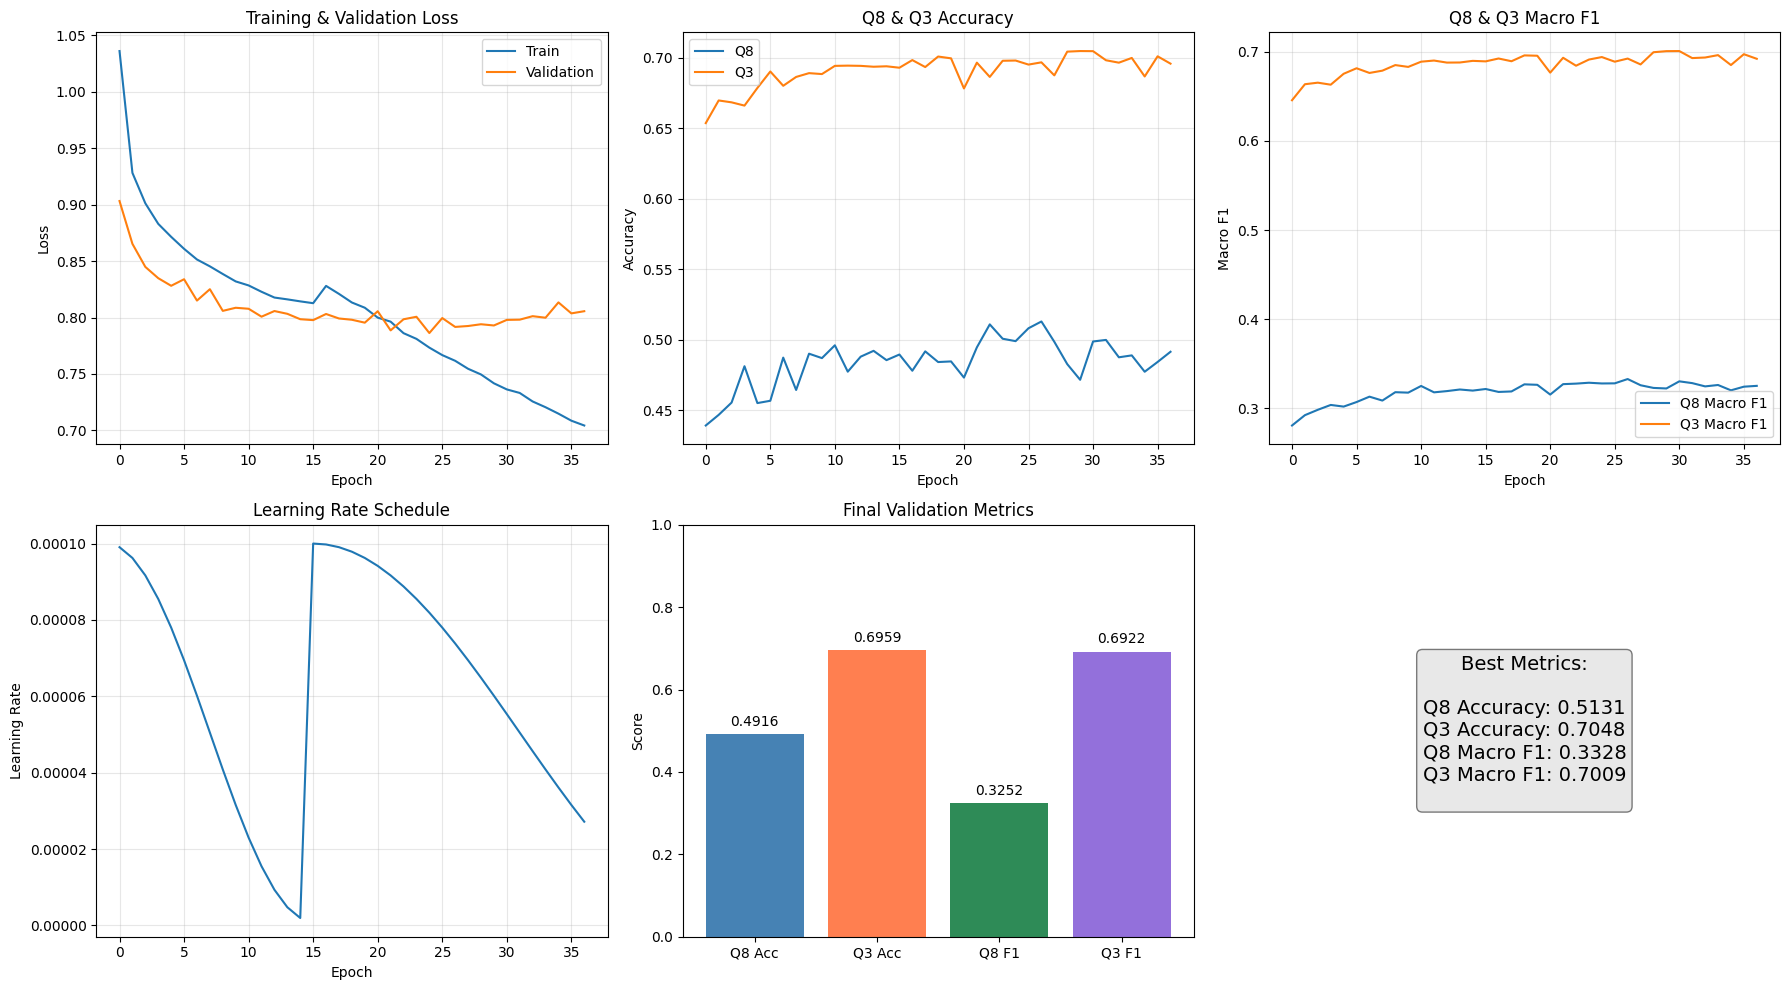

In [14]:
# Plot training history
fig = plot_training_history(history, save_path=f'{config.checkpoint_dir}/training_history.png')
fig.show()

## 8. Evaluation

In [15]:
# Load best model
checkpoint = torch.load(f'{config.checkpoint_dir}/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

Loaded best model from epoch 27


In [16]:
# Full evaluation
report = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=DEVICE,
    compute_sov=True,
)

report.print_report()

EVALUATION REPORT

============================== Q8 (8-state) ==============================
Accuracy: 0.5131 (51.31%)
Macro F1: 0.3328
SOV Score: 56.30

Per-class metrics:
Class           Precision    Recall       F1           Support   
------------------------------------------------------------
G (3₁₀-helix)   0.1190       0.4603       0.1892       6420
H (α-helix)     0.7684       0.7085       0.7372       52250
I (π-helix)     0.0000       0.0000       0.0000       23
E (β-strand)    0.6141       0.6759       0.6435       37526
B (β-bridge)    0.0482       0.2167       0.0788       1809
T (Turn)        0.3389       0.4778       0.3966       18325
S (Bend)        0.2880       0.1969       0.2339       13162
C (Coil)        0.7912       0.2529       0.3833       40857

============================== Q3 (3-state) ==============================
Accuracy: 0.6968 (69.68%)
Macro F1: 0.6925
SOV Score: 73.79

Per-class metrics:
Class           Precision    Recall       F1           Suppo

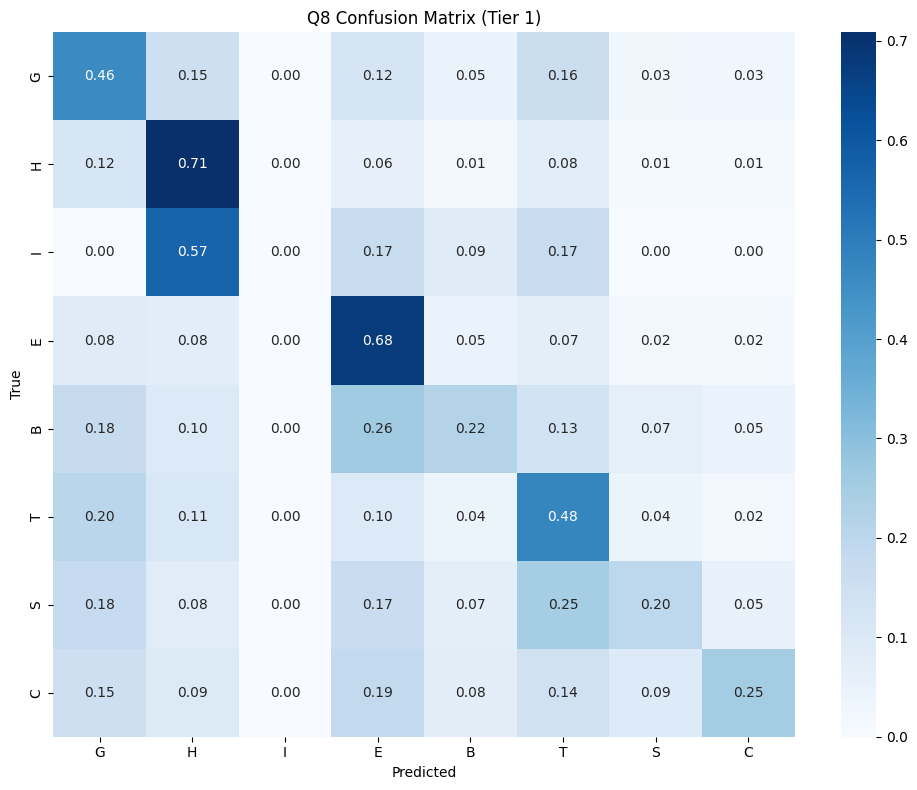

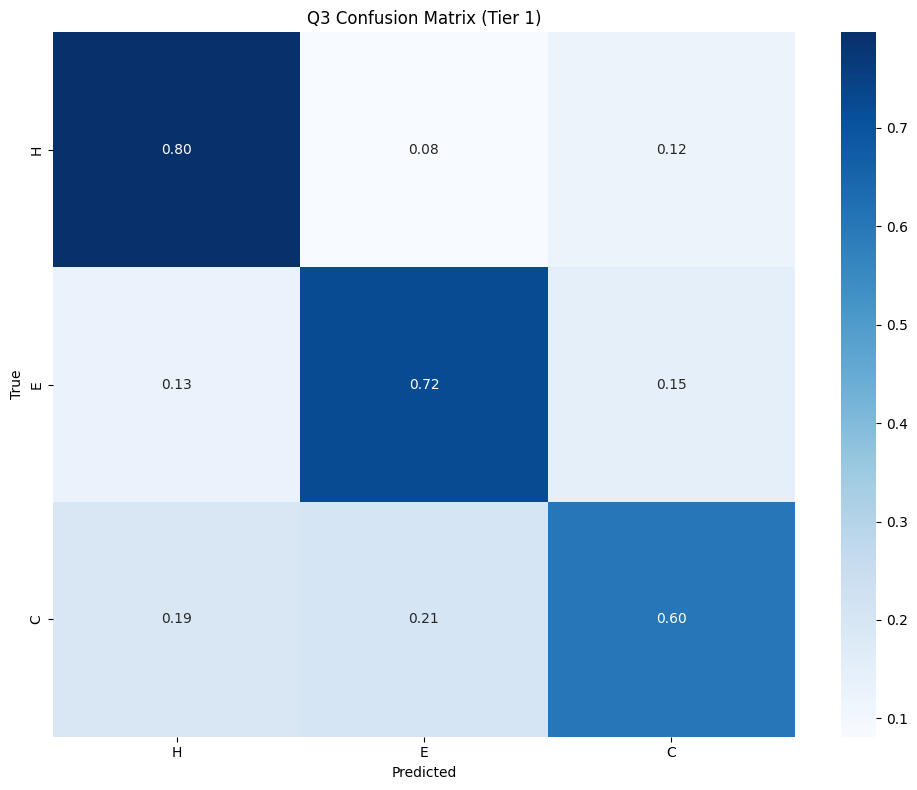

In [17]:
# Plot confusion matrices
from src.config import SST8_CLASSES, SST3_CLASSES

fig_q8 = plot_confusion_matrix(
    report.q8_confusion_matrix,
    SST8_CLASSES,
    title='Q8 Confusion Matrix (Tier 1)',
    save_path=f'{config.checkpoint_dir}/q8_confusion_matrix.png',
)

fig_q3 = plot_confusion_matrix(
    report.q3_confusion_matrix,
    SST3_CLASSES,
    title='Q3 Confusion Matrix (Tier 1)',
    save_path=f'{config.checkpoint_dir}/q3_confusion_matrix.png',
)

## 9. Summary

In [18]:
print("=" * 60)
print("TIER 1 TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest Results:")
print(f"  Q8 Accuracy: {report.q8_accuracy:.4f} ({report.q8_accuracy*100:.2f}%)")
print(f"  Q3 Accuracy: {report.q3_accuracy:.4f} ({report.q3_accuracy*100:.2f}%)")
print(f"  Q8 Macro F1: {report.q8_macro_f1:.4f}")
print(f"  Q3 Macro F1: {report.q3_macro_f1:.4f}")
if report.q8_sov:
    print(f"  Q8 SOV: {report.q8_sov:.2f}")
    print(f"  Q3 SOV: {report.q3_sov:.2f}")

print(f"\nCheckpoints saved to: {config.checkpoint_dir}")

TIER 1 TRAINING COMPLETE

Best Results:
  Q8 Accuracy: 0.5131 (51.31%)
  Q3 Accuracy: 0.6968 (69.68%)
  Q8 Macro F1: 0.3328
  Q3 Macro F1: 0.6925
  Q8 SOV: 56.30
  Q3 SOV: 73.79

Checkpoints saved to: ../../checkpoints/tier1_cnn_bilstm
